<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license.  
(c) Nicole Beisiegel</td>
</table>

In [1]:
%matplotlib inline
import h5py
import os
from HOS_Visualization import *
#import types
#import scipy as sp
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from subprocess import call

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# A High-Order Spectral Model for 3D Water Wave Simulations

## Numerical Errors

This jupyter notebook contains routines that can be utilized to compute numerical errors for the high-order spectral model. This comprises 

1. Comparing numerical simulations at different resolutions given the `*.h5` model output.
2. Computing numerical errors given an _analytical solution_ (e.g. second order Stokes wave train)

Since analytical solutions are difficult to obtain, particularly if no simplifying assumptions are made, we will concentrate on 1.

The error norms that will be most important for us are the discrete versions of the $L_1, L_2$, and $L_{\infty}$-norms. Therefore, let $(\eta_h(t), \phi_h(t))^{\top}$ be the numerical solution obtained on grid $\mathcal T_h$ at time $t$ and $(\eta_{h'}(t), \phi_{h'}(t))^{\top}$ the solution obtained on grid $\mathcal T_{h'}$ where $h,h'\in\mathbb R$ are the grid spacings and $h<h'$.
The norms are then defined as

$$\begin{aligned}
    e_{L_p}(q_{h'}(t)) &= \frac{\| q_h(t) - q_{h'}(t) \|_p}{\| q_h(t) \|_p}; \qquad  
    e_{\ell_p}(q_{h'}(t))^p = \frac{\sum_{\mathcal T_h} |q_h(t) - \tilde{q}_{h'}(t) |^p}{\sum_{\mathcal T_h} |q_h(t)|^p}, \qquad p\in \{1,2 \}\\
    e_{L_{\infty}}(q_{h'}(t)) &= \frac{\max\left| q_h(t) - q_{h'}(t) \right|}{\max \left| q_h(t) \right|}; \qquad  
    e_{\ell_{\infty}}(q_{h'}(t)) = \frac{\max_{\mathcal T_h} \left|q_h(t) - \tilde{q}_{h'}(t) \right|}{\max_{\mathcal T_h} \left|q_h(t)\right|},
\end{aligned}$$

with $q_h(t) \in \{\eta_h(t), \phi_h(t)\}$ and $\tilde{q}$ is an interpolated value.

In [15]:
def CompareFiles(DIR, fileName, fileName2, keyword, plot):
    
    f  = h5py.File(DIR+fileName,  "r")
    f2 = h5py.File(DIR+fileName2, "r")
    
    # Get the attributes that are contained in the file
    dataset  = f.keys()[:]
    dataset2 = f2.keys()[:]
    
    time  = f[dataset[dataset.index(u'time')]][0]
    time2 = f2[dataset[dataset.index(u'time')]][0]

    if (abs(time-time2) >= 10E-4): print "Files do not correspond to the same time. Please check input."
    
    # Finer Grid
    Nx   = f[dataset[dataset.index(u'Nx')]][0]
    Ny   = f[dataset[dataset.index(u'Ny')]][0]
    Lx   = f[dataset[dataset.index(u'Lx')]][0]
    Ly   = f[dataset[dataset.index(u'Ly')]][0] 
    
    xx = np.asarray([(Lx / (Nx-1)) * y for y in np.arange(0,Nx,1)])
    yy = np.asarray([(Ly / (Ny-1)) * y for y in np.arange(0,Ny,1)])
    
    # Coarser Grid
    Nx2   = f2[dataset[dataset.index(u'Nx')]][0]
    Ny2   = f2[dataset[dataset.index(u'Ny')]][0]
    Lx2   = f2[dataset[dataset.index(u'Lx')]][0]
    Ly2   = f2[dataset[dataset.index(u'Ly')]][0]
     
    xx2 = np.asarray([(Lx2 / (Nx2-1)) * x for x in np.arange(0,Nx2,1)])
    yy2 = np.asarray([(Ly2 / (Ny2-1)) * y for y in np.arange(0,Ny2,1)])
 
    # Determine the finer grid
    if (Nx > Nx2):
        Q   = f[dataset[dataset.index(keyword)]][:,:]
        X,Y = np.meshgrid(xx,yy)
        
        Q2    = f2[dataset[dataset.index(keyword)]][:,:]
        X2,Y2 = np.meshgrid(xx2,yy2)
        
    else:
        Q   = f2[dataset[dataset.index(keyword)]][:,:]
        X,Y = np.meshgrid(xx2,yy2)
        
        X2,Y2 = np.meshgrid(xx,yy)
        Q2    = f[dataset[dataset.index(keyword)]][:,:]
    
    # Interpolate from coarser to finer grid (choose between nearest, linear, cubic)
    Q2fine = griddata(np.concatenate((X2.reshape((Nx2*Ny2,1), order="F"),Y2.reshape((Nx2*Ny2,1), order="F")),axis=1),\
                      np.asarray(Q2).reshape(-1), (X,Y), method="linear")
    
    Q2fine = Q2fine.T
    
    # Initialize arrays and errors
    ell1   = 0.0
    ell2   = 0.0
    ellinf = 0.0
    
    l1   = np.zeros((Nx,Ny))
    l2   = l1.copy()

    # Compute pointwise errors
    for i in xrange(Nx):
        for j in xrange(Ny):
            
            deltaQ    = abs(Q2fine[i,j] - Q[i,j])         
            l1[i,j]   = abs(deltaQ)
            l2[i,j]   = deltaQ**2 
        
    # Compute global errors
    ell1      = np.linalg.norm(Q2fine-Q,ord=1) 
    ell1rel   = ell1 / np.linalg.norm(Q,ord=1)
    ell2      = np.linalg.norm(Q2fine-Q,ord=2) 
    ell2rel   = ell2 / np.linalg.norm(Q,ord=2)
    ellinf    = np.linalg.norm(Q2fine-Q,ord=np.inf) 
    ellinfrel = ellinf / np.linalg.norm(Q,ord=np.inf)
    
    # Plot data and error
    if (plot == "on"):
        fig = plt.figure()
        fig.set_figwidth(fig.get_figwidth() * 3)
        fig.set_figheight(fig.get_figheight() * 2)

        fig.suptitle("Numerical Errors HOS at time t="+str(round(time[0],2))+"s" ,fontsize = 16)

        plt.subplot(231)
        plt.contourf(X,Y,Q)
        plt.colorbar()
        plt.title("Fine grid simulation")
        plt.xlabel("x")
        plt.ylabel("y")

        plt.subplot(232)
        plt.contourf(X2,Y2,Q2)
        plt.colorbar()
        plt.title("Coarse grid simulation")
        plt.xlabel("x")
        plt.ylabel("y")

        plt.subplot(233)
        plt.contourf(X,Y,Q2fine)
        plt.colorbar()
        plt.title("Coarse grid simulation on finer grid")
        plt.xlabel("x")
        plt.ylabel("y")

        plt.subplot(234)
        plt.contourf(X,Y,l1)
        plt.colorbar()
        plt.title("Pointwise $L_1$ Error")
        plt.xlabel("x")
        plt.ylabel("y")

        plt.subplot(235)
        plt.contourf(X,Y,l2)
        plt.colorbar()
        plt.title("Pointwise $L_2$ Error")
        plt.xlabel("x")
        plt.ylabel("y")

        plt.subplot(236)
        plt.plot(time[0],ell1,'ro', label='$L_1$')
        plt.plot(time[0],ell2,'*',label='$L_2$')
        plt.plot(time[0],ellinf,'b+', label='$L_{\infty}$')
        plt.title("Global Errors")
        plt.xlabel("time")
        plt.ylabel("Error")
        plt.xlim(time[0]-0.5,time[0]+0.5)
        plt.legend()
    
    return ell1, ell2, ellinf

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(1.3814186997476143, 1.4297994842877988, 1.5035089761639833)

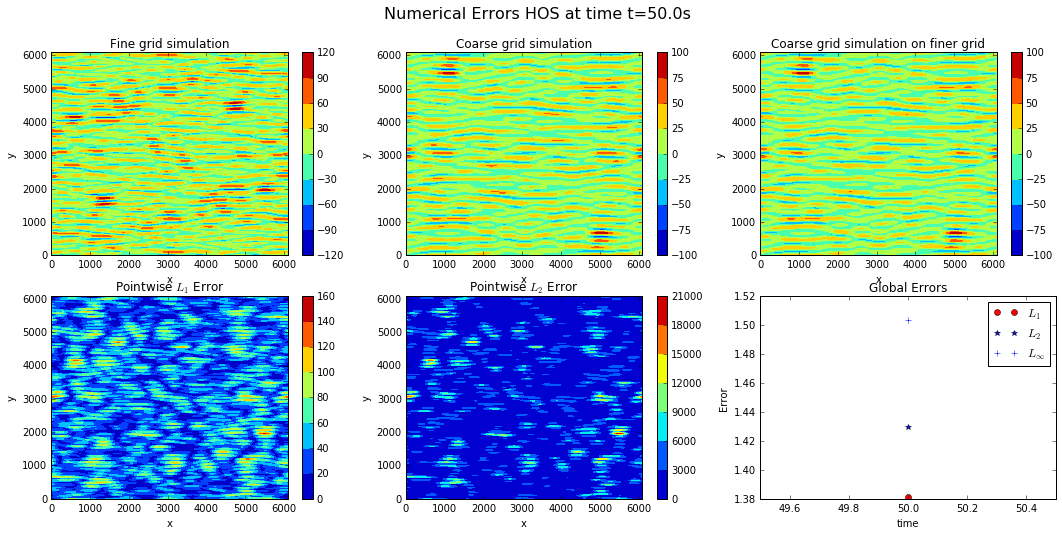

In [296]:
# Example for how to use the routine CompareFiles
DIR = "/home/nicole/Development/hos/Csource/2dpar/Error/"

fileName  = "data50.1.h5"
fileName2 = "coarse_data50.1.h5"
keyword   = str(u'phi')

CompareFiles(DIR, fileName, fileName2, keyword, plot="on")

In [16]:
def ErrorPlot(DIR, keyword):
    idx   = []
    files = []
    time  = []
 
    # Pick and sort all data files
    for file in os.listdir(DIR):
        if (file.startswith('data') & (file[4:7] != '_ex')& (file[4:7] != '_co')):
            idx.append(int(float(file[4:7])))
            files.append(file) 

    files = [x for (y,x) in sorted(zip(idx,files))]

    # Initialize errors
    ell1   = np.zeros(len(files))
    ell2   = ell1.copy()
    ellinf = ell1.copy() 
    
    for (i,fileName) in enumerate(files):
        f = h5py.File(DIR+fileName, "r")
        dataset = f.keys()[:]    
        time.append(f[dataset[dataset.index(u'time')]][0])
        
        fileName2 = str("coarse_")+fileName
        ell1[i], ell2[i], ellinf[i] = CompareFiles(DIR, fileName, fileName2, keyword, plot="off")
            
    fig = plt.figure()        
    plt.plot(time,ell1,'*',label='$L_1$')
    plt.plot(time,ell2,'ro',label='$L_2$')
    plt.plot(time,ellinf,'b+',label='$L_{\infty}$')
    plt.title("Absolute errors over time")
    plt.xlabel('time [s]')
    plt.ylabel('Errors')
    plt.legend()
    plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


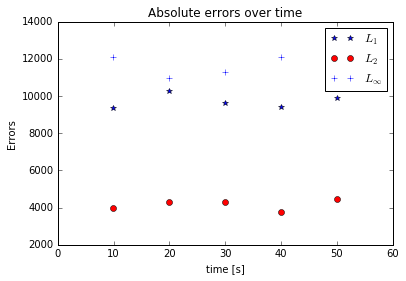

In [18]:
# note: files have to be named data.. and coarse_data.. for the time being.
DIR = "/home/nicole/Development/hos/Csource/2dpar/Error/"

keyword   = str(u'phi')
ErrorPlot(DIR,keyword)